In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats as stats

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import precision_score, recall_score
from sklearn.model_selection import train_test_split, GridSearchCV,\
cross_val_score, RandomizedSearchCV

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from pandas_profiling import ProfileReport

from sklearn.compose import ColumnTransformer,  make_column_selector as selector
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImPipeline
from imblearn.over_sampling import SMOTEN

from sklearn.metrics import plot_confusion_matrix, recall_score,\
    accuracy_score, precision_score, f1_score
from sklearn.metrics import roc_curve

from numpy import sqrt
from numpy import argmax

In [2]:
df = pd.read_csv('./Data/Terry_Stops.csv')
df.head()

,Subject Age Group,Subject ID,GO / SC Num,Terry Stop ID,Stop Resolution,Weapon Type,Officer ID,Officer YOB,Officer Gender,Officer Race,...,Reported Time,Initial Call Type,Final Call Type,Call Type,Officer Squad,Arrest Flag,Frisk Flag,Precinct,Sector,Beat
0,-,-1,20140000120677,92317,Arrest,None,7500,1984,M,Black or African American,...,11:32:00.0000000,-,-,-,SOUTH PCT 1ST W - ROBERT,N,N,South,O,O2
1,-,-1,20150000001463,28806,Field Contact,None,5670,1965,M,White,...,07:59:00.0000000,-,-,-,NaN,N,N,-,-,-
2,-,-1,20150000001516,29599,Field Contact,None,4844,1961,M,White,...,19:12:00.0000000,-,-,-,NaN,N,-,-,-,-
3,-,-1,20150000001670,32260,Field Contact,None,7539,1963,M,White,...,04:55:00.0000000,-,-,-,NaN,N,N,-,-,-
4,-,-1,20150000001739,33155,Field Contact,None,6973,1977,M,White,...,00:41:00.0000000,-,-,-,NaN,N,N,-,-,-


### Drop all irrelevant columns / columns with multicolinearity

In [ ]:
df = df.drop(['Subject ID',
              'GO / SC Num',
              'Terry Stop ID',
              'Stop Resolution',
              'Officer ID',
              'Initial Call Type',
              'Final Call Type',
              'Call Type',
              'Reported Date',
              'Beat',
              'Precinct',
              'Officer Squad'
             ], axis=1)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52712 entries, 0 to 52711
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Subject Age Group         52712 non-null  object
 1   Weapon Type               52712 non-null  object
 2   Officer YOB               52712 non-null  int64 
 3   Officer Gender            52712 non-null  object
 4   Officer Race              52712 non-null  object
 5   Subject Perceived Race    52712 non-null  object
 6   Subject Perceived Gender  52712 non-null  object
 7   Reported Time             52712 non-null  object
 8   Arrest Flag               52712 non-null  object
 9   Frisk Flag                52712 non-null  object
 10  Sector                    52712 non-null  object
dtypes: int64(1), object(10)
memory usage: 4.4+ MB


### Converting all column to the correct type

In [5]:
frisk_map = {'Y' : 1, 'N' : 0}
arrest_map = {'Y' : 1, 'N' : 0}

In [6]:
df['Frisk Flag'] = df['Frisk Flag'].map(frisk_map)
df['Arrest Flag'] = df['Arrest Flag'].map(frisk_map)

### Create bins for Officer YOB as a part of Feature Engineering

In [7]:
df['Officer_YOB_Bins'] = pd.cut(
   df['Officer YOB'], 
   [1900, 1910, 1920, 1930, 1940, 1950, 1960, 1970, 1980, 1990, 2000]
)

In [8]:
df.dropna(inplace=True)

In [9]:
df = df.drop('Officer YOB', axis = 1)

In [10]:
df.Officer_YOB_Bins = df.Officer_YOB_Bins.astype('object')

### Create simple time bins as a part of Feature Engineering

In [11]:
df['hour'] = df['Reported Time'].str[:2]

In [12]:
df['hour'] = df['hour'].astype('int')

In [13]:
df = df.drop('Reported Time', axis = 1)

### Train Test Split

In [15]:
y = df['Arrest Flag']
X = df.drop('Arrest Flag', axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state= 42)

In [16]:
y_train.value_counts(normalize=True)

0    0.909639
1    0.090361
Name: Arrest Flag, dtype: float64

### Create Dummy Model

In [20]:
dummy_model_pipe = Pipeline(steps=[
    ('dum', DummyClassifier(strategy='most_frequent'))
])

### Import ModelwithCV

In [21]:
class ModelWithCV():
    '''Structure to save the model and more easily see its crossvalidation'''
    
    def __init__(self, model, model_name, X, y, cv_now=True):
        self.model = model
        self.name = model_name
        self.X = X
        self.y = y
        # For CV results
        self.cv_results = None
        self.cv_mean = None
        self.cv_median = None
        self.cv_std = None
        #
        if cv_now:
            self.cross_validate()
        
    def cross_validate(self, X=None, y=None, kfolds=10):
        '''
        Perform cross-validation and return results.
        
        Args: 
          X:
            Optional; Training data to perform CV on. Otherwise use X from object
          y:
            Optional; Training data to perform CV on. Otherwise use y from object
          kfolds:
            Optional; Number of folds for CV (default is 10)  
        '''
        
        cv_X = X if X else self.X
        cv_y = y if y else self.y

        self.cv_results = cross_val_score(self.model, cv_X, cv_y, cv=kfolds)
        self.cv_mean = np.mean(self.cv_results)
        self.cv_median = np.median(self.cv_results)
        self.cv_std = np.std(self.cv_results)

        
    def print_cv_summary(self):
        cv_summary = (
        f'''CV Results for `{self.name}` model:
            {self.cv_mean:.5f} ± {self.cv_std:.5f} accuracy
        ''')
        print(cv_summary)

        
    def plot_cv(self, ax):
        '''
        Plot the cross-validation values using the array of results and given 
        Axis for plotting.
        '''
        ax.set_title(f'CV Results for `{self.name}` Model')
        # Thinner violinplot with higher bw
        sns.violinplot(y=self.cv_results, ax=ax, bw=.4)
        sns.swarmplot(
                y=self.cv_results,
                color='orange',
                size=10,
                alpha= 0.8,
                ax=ax
        )

        return ax

In [22]:
dummy_pipe = ModelWithCV(dummy_model_pipe, 'dummy_model', X_train, y_train)

In [23]:
dummy_pipe.print_cv_summary()

CV Results for `dummy_model` model:
            0.90964 ± 0.00011 accuracy
        


### Basic LogReg Model

In [24]:
logreg_model_pipe = Pipeline([
    ('ct', CT),
    ('logreg', LogisticRegression(random_state=42, max_iter=1000))
])

In [25]:
logreg_pipe = ModelWithCV(logreg_model_pipe, 'logreg_model', X_train, y_train)

In [26]:
logreg_pipe.print_cv_summary()

CV Results for `logreg_model` model:
            0.90956 ± 0.00128 accuracy
        


### Basic Random Forest

In [27]:
rfc_model_pipe = Pipeline([('ct', CT), ('rfc', RandomForestClassifier(random_state=42))])

In [28]:
rfc_pipe = ModelWithCV(rfc_model_pipe, 'logreg_model', X_train, y_train)
rfc_pipe.print_cv_summary()

CV Results for `logreg_model` model:
            0.90100 ± 0.00164 accuracy
        


### Basic Gradient Boost

In [29]:
gbc = GradientBoostingClassifier(random_state=42)

gbc_model_pipe = Pipeline([('ct', CT), ('gbs', gbc)])

In [30]:
gbc_pipe = ModelWithCV(gbc_model_pipe, 'gbc_model', X_train, y_train)
gbc_pipe.print_cv_summary()

CV Results for `gbc_model` model:
            0.90926 ± 0.00048 accuracy
        


Its important to note that although these appear on the surface to be running well, the following pipeline will show that this is not the case.

### Create Pipeline

In [17]:
subpipe_cat = Pipeline(steps=[
    ('cat_impute', SimpleImputer(missing_values='Unknown', strategy='most_frequent', add_indicator = True)),
    ('cat_impute2', SimpleImputer(missing_values='-', strategy='most_frequent', add_indicator = True)),
    ('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'))
])

In [18]:
CT = ColumnTransformer(transformers=[
    ('subpipe_cat', subpipe_cat, selector(dtype_include=[object, int]))
], remainder='passthrough')

In [19]:
imb_pipe = ImPipeline(steps=[
    ('ct', CT),
    ('sm', SMOTEN(sampling_strategy=0.8, random_state=42)),
    ('log', LogisticRegression(random_state=42, max_iter=1000))
])

In [32]:
imb_pipe.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('subpipe_cat',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(add_indicator=True,
                                                                                 missing_values='Unknown',
                                                                                 strategy='most_frequent')),
                                                                  ('cat_impute2',
                                                                   SimpleImputer(add_indicator=True,
                                                                                 missing_values='-',
                                                                                 strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f9782fc3520>)])),
                ('sm', SMOTEN(random_state=42, sampling_strategy=0.8)),
                ('log', LogisticRegression(max_iter=1000, random_state=42))])

In [33]:
y_hat = imb_pipe.predict(X_test)

In [34]:
print(f"""
Our model's accuracy on the test set is {round(accuracy_score(y_test, y_hat), 2)}. \n
Our model's recall on the test set is {round(recall_score(y_test, y_hat), 2)} \n
Our model's precision on the test set is {round(precision_score(y_test, y_hat), 2)} \n
Our model's f1-score on the test is {round(f1_score(y_test, y_hat), 2)}.
""")


Our model's accuracy on the test set is 0.91. 

Our model's recall on the test set is 0.11 

Our model's precision on the test set is 0.46 

Our model's f1-score on the test is 0.18.



/Users/jordanmang/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


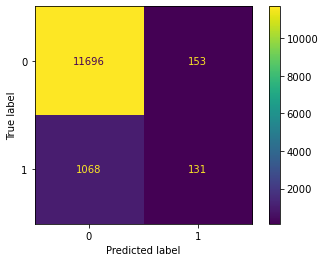

In [35]:
plot_confusion_matrix(imb_pipe, X_test, y_test);

When you put it like that... it doesn't seem all that bad? But it really isn't doing much more than predicting the most common class. It also only guessed that someone would get arrested 284 times and most of the time it was wrong. It also thought 1000 people were not going to get arrested and they did. You coul basically just assume no one ever gets arrested and come to a similar place.

The next notebook will explore more models and utalize SMOTEN to try and rebalance the model.